# 共享单车的用户写照
## by Ivy

## 探索目的

> 了解共享单车的用户群体、主要用途和时间，为提供更有针对性的服务做准备。

## 数据集介绍

> 该数据集包含有关在旧金山湾区的自行车共享系统中的单次骑行信息。下载地址为：https://s3.amazonaws.com/baywheels-data/index.html 。本次分析只下载了 2018 年 1 - 12 月的数据。

In [4]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [5]:
# load in the dataset into a pandas dataframe
if '2018-fordgobike-tripdata.csv' not in os.listdir(): # 判断当前工作目录是否存在目标数据集
    csv_list = unzip_csv() # 解压所有 zip 文件
    df = append_csv(csv_list) # 将所有 csv 文件读取并合并到一个数据集
    df.to_csv('2018-fordgobike-tripdata.csv',index=False) # 保存为一个 2018 年的数据集
else:
    df = pd.read_csv('2018-fordgobike-tripdata.csv')

In [6]:
# 这部分是数据整理
df.dropna(inplace=True)
df['member_birth_year'] = df['member_birth_year'].astype(np.int64)
column_list = df.columns.tolist()
for c in column_list:
    if '_id' in c:
        df[c] = df[c].astype(np.int64).astype(str)
    elif '_time' in c:
        df[c] = pd.to_datetime(df[c])
df.replace(['Yes','No'],[True,False],inplace=True)
df_copy = df[['duration_sec','start_time','member_birth_year','member_gender','bike_share_for_all_trip','user_type']].copy()
df_copy['start_date'] = df_copy['start_time'].dt.date
df_copy['start_week'] = df_copy['start_time'].dt.week
df_copy['start_weekday'] = df_copy['start_time'].dt.weekday
df_copy['start_hour'] = df_copy['start_time'].dt.hour
df_copy['start_month'] = df_copy['start_time'].dt.month
df_copy['is_vip'] = df_copy['user_type'] == 'Subscriber'
df_copy['age'] = 2018 - df_copy['member_birth_year']
df_copy = df_copy[df_copy['age']<90]
df_copy['is_weekend'] = df_copy['start_weekday'].isin([5,6])

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## 用户类型分布

> 图中可以看到，共享单车的大部分用户（88.6%）都是订阅用户，也就是俗称的会员。

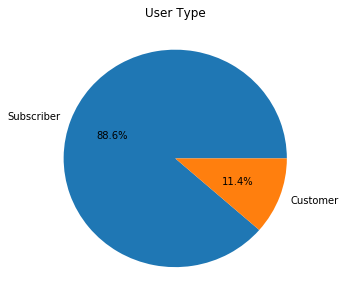

In [11]:
df_copy.user_type.value_counts().plot(kind='pie', autopct='%.1f%%',figsize=(5,5))
plt.title('User Type')
plt.ylabel('');

In [12]:
def variable_visulization(df, feature):
    '''各个因素对注册会员的影响分析对比柱状图组合'''
    f, ax = plt.subplots(1,2,figsize=(18,5))
    # 左侧显示注册会员人数对比柱状图
    df1 = df.groupby([feature,'is_vip'])['is_vip'].count().unstack()
    df1.plot(kind='bar',ax=ax[0])
    ax[0].set_ylabel('Number of trips')
    ax[0].set_title(feature + ' VS Vip VS Count')
    # 右侧显示注册会员几率柱状图
    df2 = df.groupby(feature)['is_vip'].mean()
    df2.plot(kind='bar',ax = ax[1])
    ax[1].set_ylabel('Vip Rate')
    ax[1].set_title(feature + ' VS Vip Rate')
    for i, mean in enumerate(df2):
        ax[1].text(i+0.08, mean-0.03, round(mean, 3), 
                   horizontalalignment='center',rotation=90,color='white')
    plt.show()

## 会员与散客订单数量的差异：工作日还是周末？

> 会员的订单数远远大于散客的订单数，且在工作日时，会员的订单占比更大，会员更集中在工作日使用共享单车。

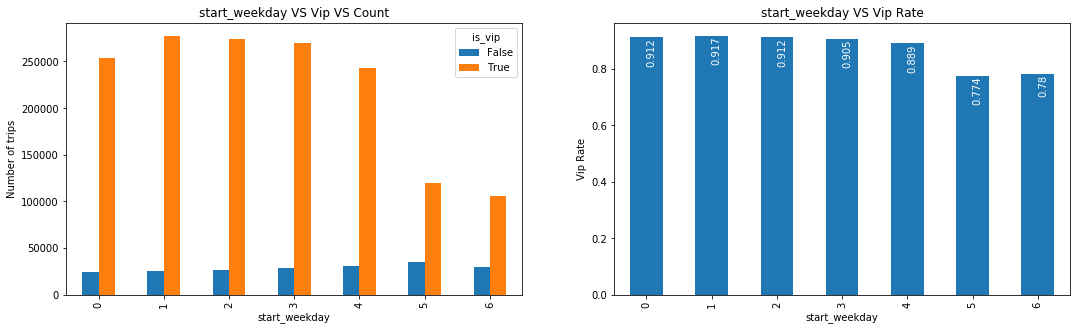

In [13]:
variable_visulization(df_copy,'start_weekday')

## 会员与散客订单数量的差异：骑行开始小时？

> 会员的订单呈现两个峰值，集中在上下班高峰期，而非会员的骑行时间分布较为均匀，白天比晚上多。进一步说明会员的骑行用途更多是通勤。

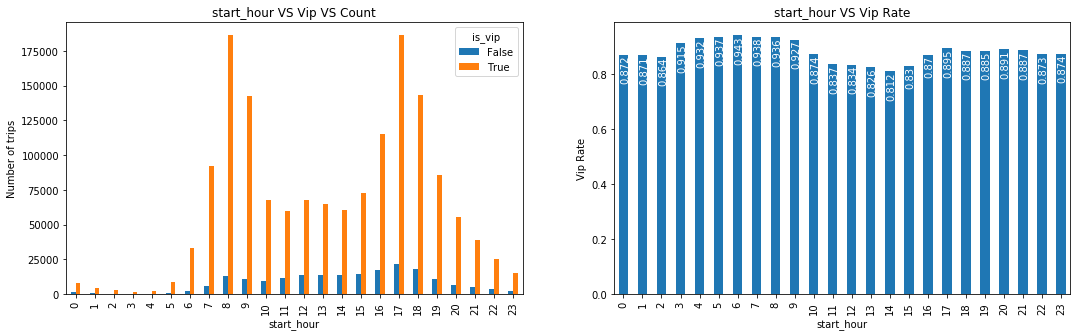

In [14]:
variable_visulization(df_copy,'start_hour')

In [16]:
def duration_hist(df,label):
    bin_edges = 10 ** np.arange(1, np.log10(df_copy.duration_sec.max())+0.1, 0.1)
    df['duration_sec'].hist(bins=bin_edges,alpha=0.5,figsize=(7,5),label=label)
    plt.xscale('log')
    tick_locs = [60, 180, 300, 600, 1200, 1800, 3600, 7200, 18000]
    tick_labels = ['1min','3min','5min','10min','20min','30min','60min','120min','300min']
    plt.xticks(tick_locs, tick_labels, rotation=90)
    plt.xlabel('Duration')
    plt.ylabel('Number of users')
    plt.title('Duration vs Vip vs Count')
    plt.legend();

## 会员 vs 骑行时长

图中可以看到：
- 会员的骑行时长更集中，主要集中在 5-20 分钟；
- 散客的骑行时长比较分散且更为均匀，峰值的坡度比较缓和。

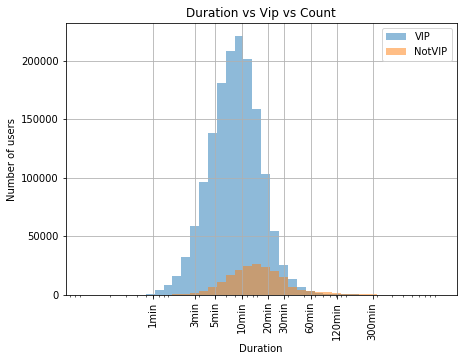

In [17]:
duration_hist(df_copy[df_copy['is_vip']==True],'VIP')
duration_hist(df_copy[df_copy['is_vip']==False],'NotVIP')

## 会员 vs 骑行时长 vs 骑行开始时间

图中可以看到：
- 夜晚和凌晨的误差条都比较长，说明数据较为分散，没有那么明确的规律；
- 左右两个子图对比，可以看出左侧的长条都相对较高，说明非会员的骑行时长比会员的骑行时长要更长；
- 右侧会员的数据中，除了凌晨的个别时间段，基本上都处于 1000 以下，且误差条非常短，说明骑行时长集中，且时长都较短；
- 除了凌晨的个别时间段，基本上所有的橙色长条都比蓝色长条要高，说明基本上周末都比工作日的骑行时长要长；

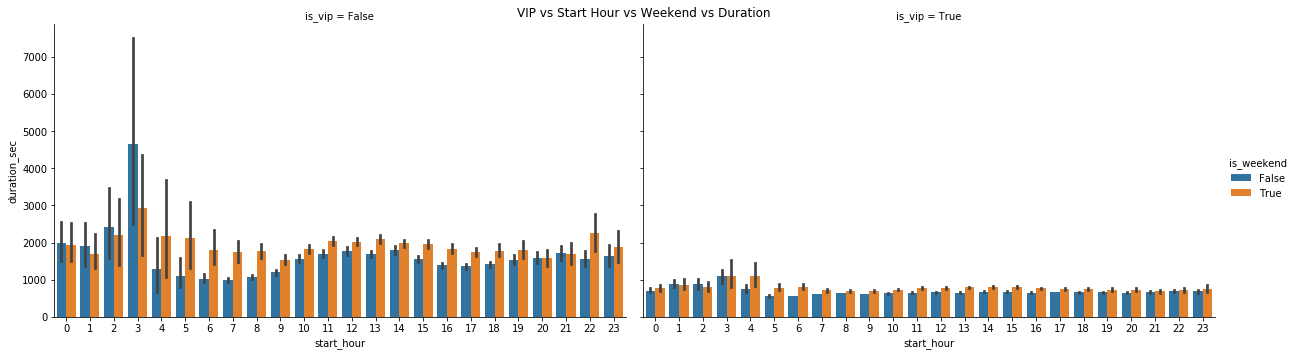

In [15]:
g = sns.catplot(x="start_hour", y="duration_sec", hue="is_weekend", col="is_vip",
                data=df_copy, kind="bar", height=5, aspect=12/7)
g.fig.suptitle('VIP vs Start Hour vs Weekend vs Duration',fontsize=12);

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert slide_deck.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!